In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import gensim
from gensim import corpora
import urllib, json

In [2]:
df = pd.read_csv("Resources/winemag-data-130k-v2.csv")

df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_one,region_two,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [87]:
df_filtered = df[['description', 'variety', 'points']]

df_filtered.head()

,description,variety,points
0,"Aromas include tropical fruit, broom, brimston...",White Blend,87
1,"This is ripe and fruity, a wine that is smooth...",Portuguese Red,87
2,"Tart and snappy, the flavors of lime flesh and...",Pinot Gris,87
3,"Pineapple rind, lemon pith and orange blossom ...",Riesling,87
4,"Much like the regular bottling from 2012, this...",Pinot Noir,87


In [88]:
description = df_filtered.groupby('variety')['description'].apply(','.join)
points = df_filtered.groupby('variety')['points'].mean()
merged = pd.merge(description,points,on='variety')
merged

,description,points
variety,,
Abouriou,"Comprised 100% of this rare variety, this wine...",87.666667
Agiorgitiko,Thyme and crushed herbs on the nose of this re...,87.031746
Aglianico,"Aromas of black-skinned fruit, leather, underb...",89.275766
Aidani,"Lemon, mineral and spice notes characterize th...",82.000000
Airen,There's a reason Airén is used as a base grape...,81.666667
...,...,...
Zinfandel,A healthy addition of 13% Petite Sirah provide...,87.828666
Zlahtina,"Grown only in Croatia, the Zlahtina grape is l...",86.000000
Zweigelt,Tender notes of red apple skin and bottled str...,88.296651


In [89]:
merged["words"] = merged["description"].str.split(" ") 

merged.head()

,description,points,words
variety,,,
Abouriou,"Comprised 100% of this rare variety, this wine...",87.666667,"[Comprised, 100%, of, this, rare, variety,, th..."
Agiorgitiko,Thyme and crushed herbs on the nose of this re...,87.031746,"[Thyme, and, crushed, herbs, on, the, nose, of..."
Aglianico,"Aromas of black-skinned fruit, leather, underb...",89.275766,"[Aromas, of, black-skinned, fruit,, leather,, ..."
Aidani,"Lemon, mineral and spice notes characterize th...",82.000000,"[Lemon,, mineral, and, spice, notes, character..."
Airen,There's a reason Airén is used as a base grape...,81.666667,"[There's, a, reason, Airén, is, used, as, a, b..."


In [90]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
merged['word_without_stopwords'] = merged['words'].apply(lambda x: ','.join([word for word in x if word not in (stop)]))
merged=pd.DataFrame(merged)
merged.head()

,description,points,words,word_without_stopwords
variety,,,,
Abouriou,"Comprised 100% of this rare variety, this wine...",87.666667,"[Comprised, 100%, of, this, rare, variety,, th...","Comprised,100%,rare,variety,,wine,given,time,f..."
Agiorgitiko,Thyme and crushed herbs on the nose of this re...,87.031746,"[Thyme, and, crushed, herbs, on, the, nose, of...","Thyme,crushed,herbs,nose,red,lead,flavors,swee..."
Aglianico,"Aromas of black-skinned fruit, leather, underb...",89.275766,"[Aromas, of, black-skinned, fruit,, leather,, ...","Aromas,black-skinned,fruit,,leather,,underbrus..."
Aidani,"Lemon, mineral and spice notes characterize th...",82.000000,"[Lemon,, mineral, and, spice, notes, character...","Lemon,,mineral,spice,notes,characterize,indige..."
Airen,There's a reason Airén is used as a base grape...,81.666667,"[There's, a, reason, Airén, is, used, as, a, b...","There's,reason,Airén,used,base,grape,brandy,Sh..."


In [76]:
from sklearn.feature_extraction.text import HashingVectorizer
vectorizer = HashingVectorizer(n_features=2**20)
merged["hashed"]= vectorizer.fit_transform(merged.word_without_stopwords)

In [79]:
merged['hashed']

variety
Abouriou         (0, 6834)\t-0.08980265101338746\n  (0, 8562)...
Agiorgitiko      (0, 6834)\t-0.08980265101338746\n  (0, 8562)...
Aglianico        (0, 6834)\t-0.08980265101338746\n  (0, 8562)...
Aidani           (0, 6834)\t-0.08980265101338746\n  (0, 8562)...
Airen            (0, 6834)\t-0.08980265101338746\n  (0, 8562)...
                                     ...                        
Zinfandel        (0, 6834)\t-0.08980265101338746\n  (0, 8562)...
Zlahtina         (0, 6834)\t-0.08980265101338746\n  (0, 8562)...
Zweigelt         (0, 6834)\t-0.08980265101338746\n  (0, 8562)...
Çalkarası        (0, 6834)\t-0.08980265101338746\n  (0, 8562)...
Žilavka          (0, 6834)\t-0.08980265101338746\n  (0, 8562)...
Name: hashed, Length: 707, dtype: object

In [93]:
merged['hashed_v2']=[hash(i) for i in merged.word_without_stopwords]
merged

,description,points,words,word_without_stopwords,hashed_v2
variety,,,,,
Abouriou,"Comprised 100% of this rare variety, this wine...",87.666667,"[Comprised, 100%, of, this, rare, variety,, th...","Comprised,100%,rare,variety,,wine,given,time,f...",-5024581027058728027
Agiorgitiko,Thyme and crushed herbs on the nose of this re...,87.031746,"[Thyme, and, crushed, herbs, on, the, nose, of...","Thyme,crushed,herbs,nose,red,lead,flavors,swee...",2026848675783175986
Aglianico,"Aromas of black-skinned fruit, leather, underb...",89.275766,"[Aromas, of, black-skinned, fruit,, leather,, ...","Aromas,black-skinned,fruit,,leather,,underbrus...",1303809372350832381
Aidani,"Lemon, mineral and spice notes characterize th...",82.000000,"[Lemon,, mineral, and, spice, notes, character...","Lemon,,mineral,spice,notes,characterize,indige...",9082783476489652362
Airen,There's a reason Airén is used as a base grape...,81.666667,"[There's, a, reason, Airén, is, used, as, a, b...","There's,reason,Airén,used,base,grape,brandy,Sh...",5248699126462356367
...,...,...,...,...,...
Zinfandel,A healthy addition of 13% Petite Sirah provide...,87.828666,"[A, healthy, addition, of, 13%, Petite, Sirah,...","A,healthy,addition,13%,Petite,Sirah,provides,a...",4041715227427613281
Zlahtina,"Grown only in Croatia, the Zlahtina grape is l...",86.000000,"[Grown, only, in, Croatia,, the, Zlahtina, gra...","Grown,Croatia,,Zlahtina,grape,light,,refreshin...",-9110862068146268194
Zweigelt,Tender notes of red apple skin and bottled str...,88.296651,"[Tender, notes, of, red, apple, skin, and, bot...","Tender,notes,red,apple,skin,bottled,strawberri...",7205375094571771052


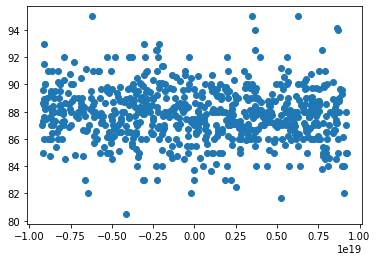

In [97]:
import numpy as np
data=merged[['hashed_v2','points']]
x=merged['hashed_v2']
y=merged['points']
plt.scatter(x,y)

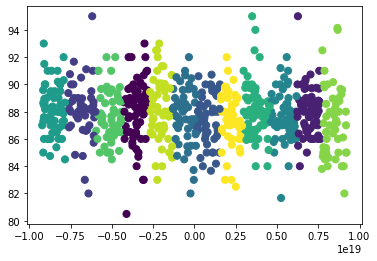

In [99]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=12)
kmeans.fit(data)
predicted_clusters = kmeans.predict(data)
plt.scatter(x,y, c=predicted_clusters, s=50, cmap='viridis')
plt.show()

In [100]:
# Print the cluster centers and cluster labels
centers = kmeans.cluster_centers_
labels = kmeans.labels_

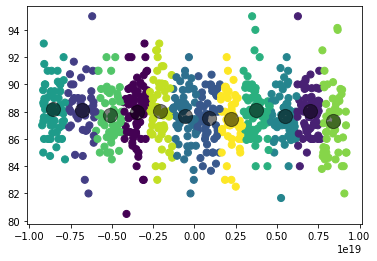

In [101]:
plt.scatter(x,y, c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

plt.show()